In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np

In [2]:
data = np.load('./AF4025.npz')

In [3]:
signal_data = data['signal']
length = 1985
signal_data = signal_data[:-(signal_data.shape[0] % length)] / data['norm_factor']

In [16]:
signal_data_batched = signal_data.reshape((-1, length)).astype(np.float32)
np.random.shuffle(signal_data_batched)

In [5]:
signal_data_batched.shape

(75924, 1985)

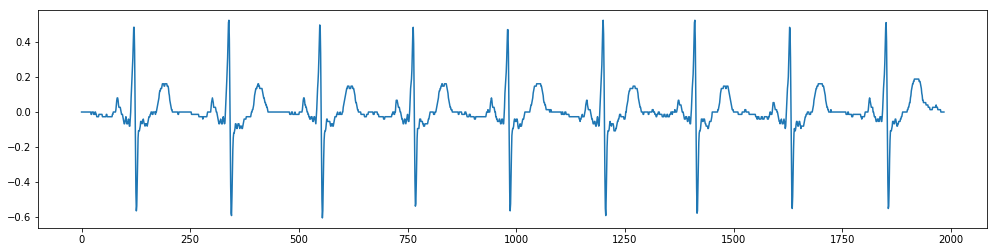

In [6]:
plt.figure(figsize=(17,4))
plt.plot(np.arange(length), signal_data_batched[2000])

In [7]:
import torch

In [8]:
data = torch.from_numpy(signal_data_batched[30:40, None, :].astype(np.float32))

In [9]:
encode = torch.nn.Sequential(
    torch.nn.Conv1d(
        in_channels=1,
        out_channels=64,
        kernel_size=257,
        stride=64,
        dilation=1, groups=1, bias=True
    ),
    torch.nn.ELU(),
    torch.nn.Conv1d(
        in_channels=64,
        out_channels=128,
        kernel_size=5,
        stride=1,
        dilation=1, groups=1, bias=True
    ),
    torch.nn.ELU(),
    torch.nn.Conv1d(
        in_channels=128,
        out_channels=256,
        kernel_size=5,
        stride=1,
        dilation=2, groups=1, bias=True
    )
)

(256, 16)

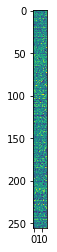

In [10]:
conved_0 = encode(data).detach().numpy()[0]
plt.imshow(conved_0, interpolation="None")
conved_0.shape

In [11]:
decode = torch.nn.Sequential(
    torch.nn.ConvTranspose1d(
        in_channels=256,
        out_channels=128,
        kernel_size=5,
        stride=1,
        dilation=2, groups=1, bias=True
    ),
    torch.nn.ELU(),
    torch.nn.ConvTranspose1d(
        in_channels=128,
        out_channels=64,
        kernel_size=5,
        stride=1,
        dilation=1, groups=1, bias=True
    ),
    torch.nn.ELU(),
    torch.nn.ConvTranspose1d(
        in_channels=64,
        out_channels=1,
        kernel_size=257,
        stride=64,
        dilation=1, groups=1, bias=True
    )
)

(1, 1985)

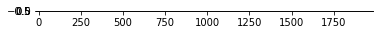

In [15]:
conved_0 = decode(encode(data)).detach().numpy()[0]
plt.imshow(conved_0, interpolation="None")
conved_0.shape

In [20]:
import torch.optim as optim
optimizer = optim.Adam(
    list(decode.parameters()) + list(encode.parameters()), lr=3e-4)

batch_size = 10
batch_count = signal_data_batched.shape[0] // batch_size
for epoch in range(1):
    running_loss = 0.0
    for i in range(batch_count):
        # get the inputs
        data = signal_data_batched[i * batch_size:(i + 1) * batch_size, None, :]
        input = torch.from_numpy(data.astype(np.float32))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = decode(encode(input))
        loss = torch.mean(torch.sum((output - input)**2, dim=1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 1.107
[1,  4000] loss: 0.879


KeyboardInterrupt: 